In [34]:
import cv2
import matplotlib.pyplot as plt
import numpy as np
import torch
from torchvision import datasets
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from torch.optim import SGD
import random


In [2]:
img = cv2.imread("Sandip.jpg")

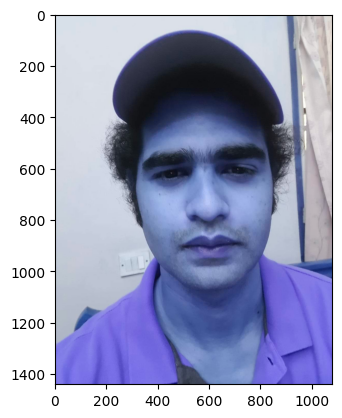

In [3]:
# Plotting the image
plt.imshow(img)
plt.show()

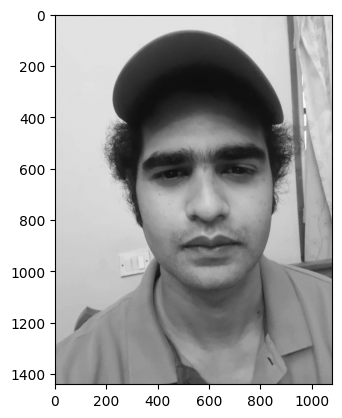

In [4]:
# Converting the bgr image to greayscale and plotting it
img_gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY) 
plt.imshow(img_gray, cmap="gray")
plt.show()

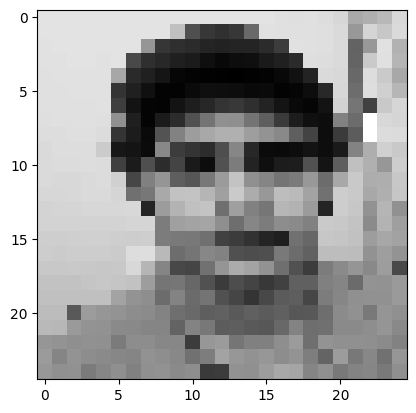

In [5]:
img_gray_small = cv2.resize(img_gray, dsize=(25, 25))
plt.imshow(img_gray_small, cmap="gray")
plt.show()

In [6]:
print(img_gray_small)

[[226 226 226 226 226 227 226 226 226 226 226 226 226 226 226 226 223 222
  223 220 215 172 178 186 216]
 [226 226 226 226 226 226 226 226 226 193  89  67  62  67 114 224 223 223
  223 222 217 157 213 200 217]
 [224 226 226 226 226 226 226 155  66  60  56  51  48  50  51  56  72 224
  223 222 217 108 157 224 181]
 [224 224 226 226 224 226  85  60  54  45  41  30  24  28  30  40  47  56
  221 220 217 109 203 223 183]
 [223 224 224 224 224 170  55  47  36  22  19  18  17  16  18  19  24  32
   49 217 216 112 220 203 171]
 [223 223 224 224 224  65  46  31  19  19  26  30  29  28  25  26  19  21
   28  54 215 117 221 208 184]
 [223 223 223 223 224  74  34  20  19  34  44  52  65  68  60  49  35  25
   21  34 211 124  76 202 214]
 [222 223 223 223 222 149  45  20  41  58  92 123 149 148 123 103  70  43
   31  28 136 116 252 216 213]
 [220 220 222 222 219  65  42  26  93 136 161 171 179 179 162 152 143 104
   78  28  71 101 252 219 218]
 [217 220 220 220 204  38  35  27 142  72  64  57  88 1

In [7]:
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

In [8]:
img.shape

(1440, 1080, 3)

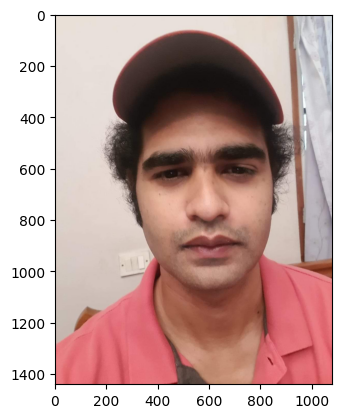

In [9]:
plt.imshow(img)
plt.show()

In [10]:
crop = img[-4:, -4:]

In [11]:
print(crop)

[[[231 106 110]
  [231 106 110]
  [230 105 109]
  [230 105 109]]

 [[231 106 110]
  [231 106 110]
  [230 105 109]
  [230 105 109]]

 [[231 106 110]
  [231 106 110]
  [230 105 109]
  [230 105 109]]

 [[231 106 110]
  [231 106 110]
  [230 105 109]
  [230 105 109]]]


In [13]:
fmnist = datasets.FashionMNIST(root="./data", download=True, train=True)

In [14]:
tr_images = fmnist.data
tr_targets = fmnist.targets

In [15]:
tr_images.shape, tr_targets.shape

(torch.Size([60000, 28, 28]), torch.Size([60000]))

In [16]:
fmnist.classes

['T-shirt/top',
 'Trouser',
 'Pullover',
 'Dress',
 'Coat',
 'Sandal',
 'Shirt',
 'Sneaker',
 'Bag',
 'Ankle boot']

In [17]:
tr_targets.unique()

tensor([0, 1, 2, 3, 4, 5, 6, 7, 8, 9])

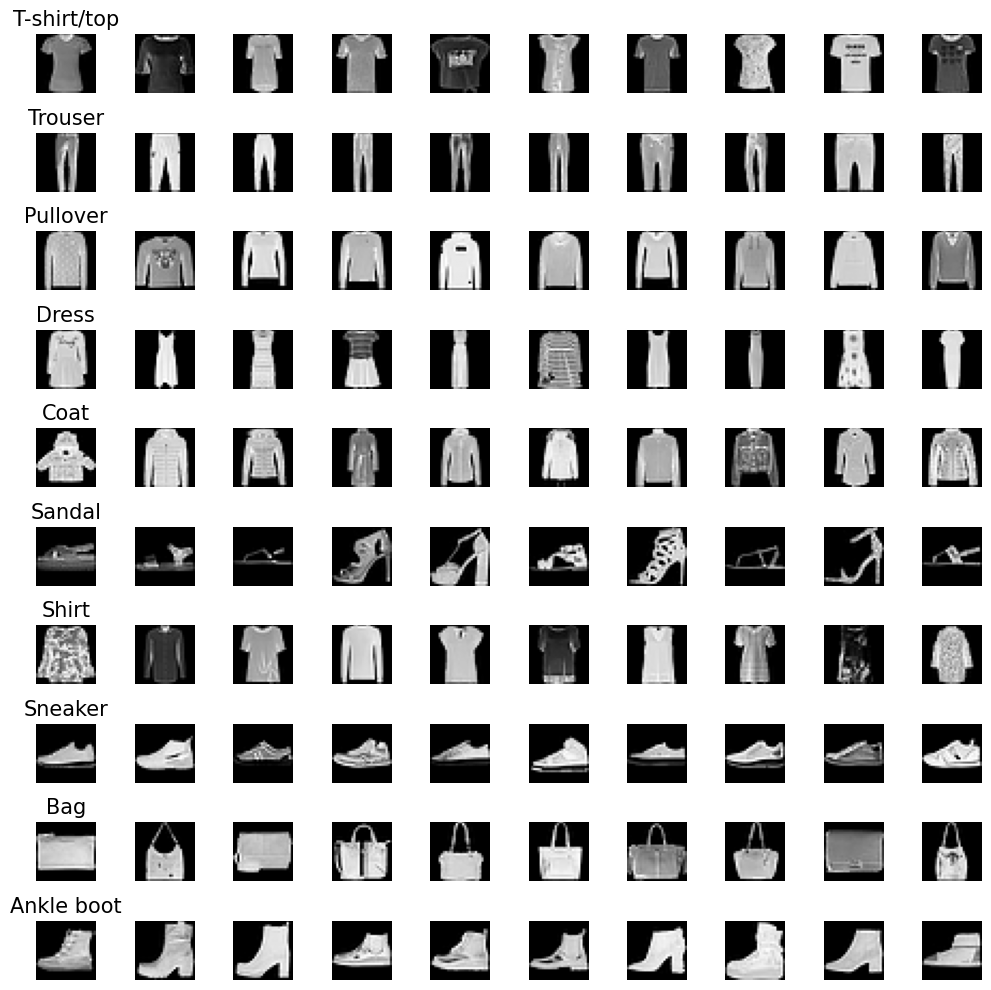

In [18]:
# Plotting random images in the dataset
R, C = len(tr_targets.unique()), 10
fig, ax = plt.subplots(nrows=10, ncols=10, figsize=(10, 10))
for label_class, plot_row in enumerate(ax):
    label_x_rows = np.where(tr_targets==label_class)[0]
    plot_row[0].set_title(fmnist.classes[label_class], fontsize=15)
    for plot_cell in plot_row:
        plot_cell.grid(False)
        plot_cell.axis("off")
        iS = np.random.choice(label_x_rows)
        S, y = tr_images[iS], tr_targets[iS]
        plot_cell.imshow(S, cmap="gray")
plt.tight_layout()
plt.show()


In [19]:
device = "cuda" if torch.cuda.is_available() else "cpu"

In [20]:
print(device)

cuda


In [21]:
class FMNISTDataset(Dataset):
    """Class which fetches the dataset"""
    def __init__(self, S, y):
        S = S.float()/255 # Converting the input into floating point numbers and scaling the input to (0, 1)
        S = S.view(-1, 28*28) # Flattening the input to 28*28 numeric values
        self.S, self.y = S, y
    def __getitem__(self, iS):
        """ This method contains logic for what should be returned 
            when we ask for iS th datapoint
        """
        S, y = self.S[iS], self.y[iS]
        return S.to(device), y.to(device)
    def __len__(self):
        """ This method computes the number of datapoints in the dataset
        """
        return len(self.S)

In [22]:
def get_data():
    """Function generates a training dataloader from the dataset.
    This will sample 32 datapoints at random for each batch"""
    train = FMNISTDataset(tr_images, tr_targets)
    trn_dl = DataLoader(train, batch_size=32, shuffle=True)
    return trn_dl

In [23]:
def get_model():
    """Creating a neural net(with one hidden layer of 1000 neurons and a 10 neuron output layer), 
    the loss function(cross entropy) and the optimizer(stochastic gradient decsent)"""
    SNet = nn.Sequential(
        nn.Linear(28*28, 1000),
        nn.ReLU(),
        nn.Linear(1000, 10)
    ).to(device)
    loss_fn = nn.CrossEntropyLoss()
    optimizer = SGD(SNet.parameters(), lr=1e-2)
    return SNet, loss_fn, optimizer

In [24]:
def train_batch(S, y, SNet, optimizer, loss_fn):
    """This function will train the neural net on a 
       batch of images"""
    SNet.train() # Tells the neural net that you are training it
    prediction = SNet(S)
    batch_loss = loss_fn(prediction, y) # Computing the loss value
    batch_loss.backward() # Computing the gradients of the loss fn wrt the parameters of the neural net
    optimizer.step() # Updating the values of the parameters of the neural net 
    optimizer.zero_grad() # Flush gradients memory for next batch of calculations
    return batch_loss.item()

In [25]:
@torch.no_grad() 
def accuracy(S, y, SNet):
    """This function calculates whether the model's predictions for each input in the batch are correct, 
       comparing the predicted class (from the argmax of the output logits) with the true class labels.
       It then returns a list of booleans, where each element is True if the corresponding prediction 
       was correct and False if it was incorrect."""
    SNet.eval() # sets the neural net to evaluation mode, disabling operations like dropout, useful for inference and testing
    prediction = SNet(S) 
    max_values, argmaxes = prediction.max(-1) 
    is_correct = argmaxes == y
    return is_correct.cpu().numpy().tolist()

In [26]:
# Initialize the neural net, loss, optimizer and dataloaders
trn_dl = get_data()
SNet, loss_fn, optimizer = get_model()

In [27]:
print(SNet)

Sequential(
  (0): Linear(in_features=784, out_features=1000, bias=True)
  (1): ReLU()
  (2): Linear(in_features=1000, out_features=10, bias=True)
)


In [28]:
# Training the neural net for five epochs
losses, accuracies = [], [] # Initializing the lists that will contain the accuracy and loss values at every epoch
for epoch in range(5): # Training the neural net for 5 epochs
    print(epoch)
    epoch_losses, epoch_accuracies = [], [] # Initializing the lists that will contain the accuracy and loss value at every batch
    for iS, batch in enumerate(iter(trn_dl)): # Creating batches of training data by iterating through the dataloader
        S, y = batch
        batch_loss = train_batch(S, y, SNet, optimizer, loss_fn) # train the batch with the aid of the train_batch function and compute the loss
        #print(batch_loss)
        epoch_losses.append(batch_loss) # Storing the batch loss to the epoch_losses list
    epoch_loss = np.array(epoch_losses).mean() # Computing the loss value for the epoch
    # Computing the accuracy of the prediction at the end of training after every batch
    for iS, batch in enumerate(iter(trn_dl)):
        S, y = batch
        is_correct = accuracy(S, y, SNet) 
        #print(is_correct)
        epoch_accuracies.extend(is_correct) 
    epoch_accuracy = np.mean(epoch_accuracies) # Computing the accuracy value for the epoch
    # Storing the epoch loss and accuracy in the respective lists
    losses.append(epoch_loss)
    accuracies.append(epoch_accuracy)

0
1
2
3
4


In [29]:
losses

[0.8479391979058584,
 0.5376930494228999,
 0.4831526899735133,
 0.45450420110225676,
 0.4348497391740481]

In [30]:
accuracies

[0.8067333333333333, 0.82955, 0.84095, 0.8505166666666667, 0.8508]

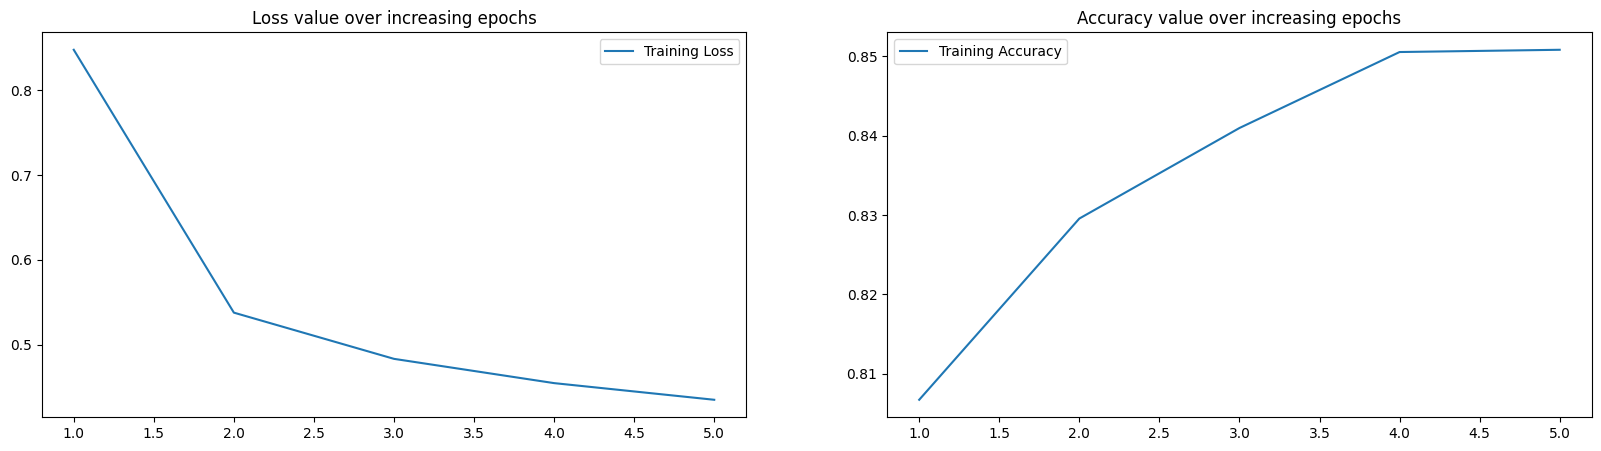

In [31]:
epochs = np.arange(5) + 1
plt.figure(figsize=(20, 5))
plt.subplot(121)
plt.title("Loss value over increasing epochs")
plt.plot(epochs, losses, label="Training Loss")
plt.legend()
plt.subplot(122)
plt.title("Accuracy value over increasing epochs")
plt.plot(epochs, accuracies, label="Training Accuracy")
plt.legend()
plt.show()

In [32]:
SNet.state_dict()

OrderedDict([('0.weight',
              tensor([[-1.3623e-02, -2.8355e-02, -9.9375e-05,  ..., -1.2077e-03,
                       -7.5316e-03, -2.5074e-02],
                      [ 2.3661e-02, -2.5749e-02,  1.3343e-02,  ..., -2.0905e-02,
                       -3.4592e-02, -3.1284e-02],
                      [ 3.0293e-02,  2.5151e-02, -4.8707e-03,  ...,  3.0476e-02,
                        1.4506e-02,  6.1192e-05],
                      ...,
                      [-2.5633e-03, -3.1854e-02,  2.0381e-02,  ..., -2.8103e-03,
                        1.7442e-02,  6.8638e-03],
                      [ 2.0892e-02, -1.3393e-02,  1.4892e-02,  ...,  2.8329e-02,
                        2.3872e-02, -1.5790e-02],
                      [ 1.4249e-03,  1.6909e-02,  2.0686e-04,  ..., -3.1066e-02,
                        5.9445e-04,  1.2335e-02]], device='cuda:0')),
             ('0.bias',
              tensor([ 2.5334e-02, -1.7878e-02, -5.0249e-02,  5.1819e-02, -1.0085e-02,
                      -2.0520e

In [35]:
# Selecting a random batch
batch_idx = random.randint(0, len(trn_dl) - 1)
# Creating an iterator to go through the dataloader
data_iter = iter(trn_dl)
# Skip batches until you reach the random batch index
for _ in range(batch_idx):
    next(data_iter)
# Get the random batch
inputs, labels = next(data_iter)

In [36]:
# Disable gradient computation for inference
with torch.no_grad():
    outputs = SNet(inputs) # Forward pass through the neural net
    _, predicted = torch.max(outputs, 1) # Get the class with the highest probability

In [37]:
# Predicted Output for the random batch
predicted 

tensor([6, 8, 2, 3, 0, 0, 0, 0, 2, 9, 1, 3, 3, 9, 4, 0, 0, 1, 6, 6, 6, 4, 8, 8,
        4, 6, 3, 0, 3, 4, 7, 5], device='cuda:0')

In [38]:
# Original Output for the random batch
labels

tensor([6, 8, 6, 3, 0, 6, 0, 0, 2, 9, 1, 3, 3, 9, 4, 0, 0, 1, 0, 6, 6, 2, 8, 8,
        4, 2, 3, 0, 1, 4, 7, 5], device='cuda:0')

In [43]:
# Comparing the predicted output to the original output
predicted == labels, torch.sum(predicted == labels)

(tensor([ True,  True, False,  True,  True, False,  True,  True,  True,  True,
          True,  True,  True,  True,  True,  True,  True,  True, False,  True,
          True, False,  True,  True,  True, False,  True,  True, False,  True,
          True,  True], device='cuda:0'),
 tensor(26, device='cuda:0'))